Отчет подготовлен Жибоедовой Анастасией Ozon_Masters_2020

In [1]:
#!pip install scikit-image opencv-python albumentations

In [2]:
#standart
import numpy as np
import pandas as pd
import time
from tqdm import tqdm
import random
#standart_ml
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
#datasets
from sklearn import datasets
#visualization
import matplotlib.pylab as plt
%matplotlib inline
#images
import skimage
import cv2
#knn
from sklearn.neighbors import KNeighborsClassifier
from knn.classification import KNNClassifier
from knn.distances import euclidean_distance, cosine_distance
from knn.model_selection import knn_cross_val_score

In [3]:
#auto reload
%load_ext autoreload
%autoreload 2

## Эксперименты
Эксперименты будут проведены на датасете MNIST. MNIST – датасет из изображений рукописных цифр размером 28х28, каждый пиксель которого представляет собой оттенок серого. Для этого
* cкачаем датасет при помощи бибилотеки sklearn.datasets
* разобьем на обучающую и тестовую выборку, размеров 60 и 10 тысяч, соответственно
* визуализируем случайные элементы

In [4]:
images, labels = datasets.fetch_openml('mnist_784', version=1, cache=True, return_X_y=True)
labels = labels.astype(int)
images.shape

(70000, 784)

In [5]:
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=int(10e3), random_state=42)
m_train, m_test = X_train.shape[0], X_test.shape[0]
n_train, n_test = X_train.shape[1], X_test.shape[1]
X_train.shape, X_test.shape

((60000, 784), (10000, 784))

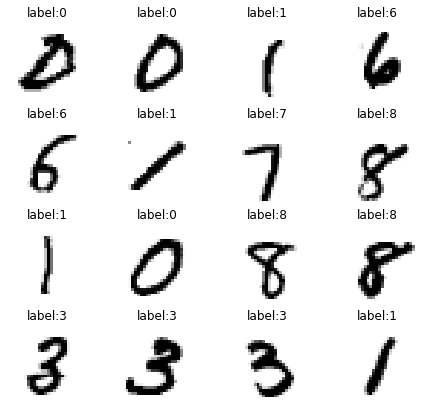

In [7]:
from plot import plot_mnist
plot_mnist(images, labels, 4, 4)

### №1
Выберем случайные подмножества признаков разных размеров (10,20,100) и замерим время работы всех 4-х алгоритмов.

In [8]:
predictions = {}
times = {}
for count in tqdm([10, 20, 100]):
    features_ind = np.random.choice(range(n_train), count)
    for algorithm in tqdm(['kd_tree', 'brute', 'ball_tree', "my_own"]):
        start = time.time()
        clf = KNNClassifier(n_neighbors=5, algorithm=algorithm, 
                            metric='euclidean', weights='uniform')
        clf.fit(X_train[:,features_ind], y_train)
        try:
            predictions[algorithm][count] = clf.predict(X_test[:,features_ind])
        except:
            predictions[algorithm] = {}
            predictions[algorithm][count] = clf.predict(X_test[:,features_ind])
        try:
            times[algorithm][count] = round(time.time()-start,1)
        except:
            times[algorithm] = {}
            times[algorithm][count] = round(time.time()-start,1)

100%|██████████| 3/3 [10:46<00:00, 215.59s/it]


Построим графики работы алгоритмов в зависимости от заданных условий: разных размерностей признакового пространства. 

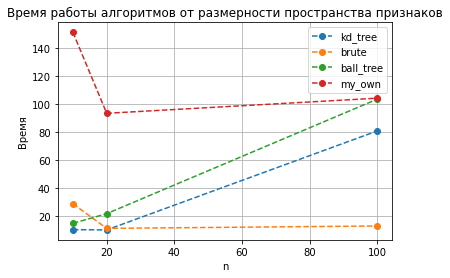

In [9]:
x = [10,20,100]
for algorithm in ['kd_tree', 'brute', 'ball_tree', "my_own"]:
    y = list(times[algorithm].values())
    plt.plot(x, y,'o--', label=algorithm)
plt.grid(True)
plt.xlabel(u'n')
plt.ylabel(u'Время')
plt.title(u'Время работы алгоритмов от размерности пространства признаков')
plt.legend()
plt.show()

*  Самым быстрым алгоритмом на нашем наборе данных оказался - brute. При чем скорость работы уменьшилась с увеличением размерности. 
*  Время работы реализованного алгоритма уменьшается с увеличение размерности как и у brute, это скорее зависимость от работы процессора, чем алгоритма.
* Время работы алгоритмов kd_tree и ball_tree сильно увеличивается с увеличением размерности. Размерность не влияет на глубину дерева и соответственно количество циклов, но по всей видимости влияет на скорость определения положения точки относительно плоскости.

In [11]:
for count in [10, 20, 100]:
    print('Dimension: {}'.format(count))
    for algorithm in ['kd_tree', 'brute', 'ball_tree', "my_own"]:
        score = accuracy_score(predictions[algorithm][count], y_test)
        print("Algorithm: {} ------- Accuracy score: {}".format(algorithm, score))
    print('----------------------------------------------------------')

Dimension: 10
Algorithm: kd_tree ------- Accuracy score: 0.2526
Algorithm: brute ------- Accuracy score: 0.2053
Algorithm: ball_tree ------- Accuracy score: 0.2513
Algorithm: my_own ------- Accuracy score: 0.2053
----------------------------------------------------------
Dimension: 20
Algorithm: kd_tree ------- Accuracy score: 0.4636
Algorithm: brute ------- Accuracy score: 0.4654
Algorithm: ball_tree ------- Accuracy score: 0.4638
Algorithm: my_own ------- Accuracy score: 0.4654
----------------------------------------------------------
Dimension: 100
Algorithm: kd_tree ------- Accuracy score: 0.8607
Algorithm: brute ------- Accuracy score: 0.8607
Algorithm: ball_tree ------- Accuracy score: 0.8607
Algorithm: my_own ------- Accuracy score: 0.8607
----------------------------------------------------------


На малых размерностях качество классификации слишком мало, поскольку мы выбираем атрибуты случайным образом, а вот если применить SVD разложение и оставить только аттрибуты с максимальными сингулярными числами, это могло бы улучшить качество. 
Можно было бы посмотреть на этот результат, возожно это поможет уйти от проклятия размерностей при этом улучшив точность и не увеличивая работу алготмов на деревьях.

### №2
Воспользуемся кросс-валидацией с 3-фолдами, реализованной в библиотеке knn. Оценим точность работы алгоритма при различных значениях соседей и метрик. 

Для сравнения работы классификатора с кросс валидацией на разных параметрах воспользуется алгоритмом brute, поскольку из предыдущего пунка выяснили, что он работает быстрее остальных алгоритмов и соответственно затратит меньше всего времени.

In [81]:
k_list = np.arange(1,11)
algorithm = 'brute'
metrics = ['euclidean', 'cosine']
result_unif = []
for metric in tqdm(metrics):
    result_unif.append(knn_cross_val_score(images, labels, k_list, cv=KFold(n_splits=3), 
                                   algorithm=algorithm, metric=metric))

100%|██████████| 2/2 [04:05<00:00, 122.67s/it]


Построим графики зависимости точности алгоритма от количества ближайших соседей для каждой метрики отдельно.

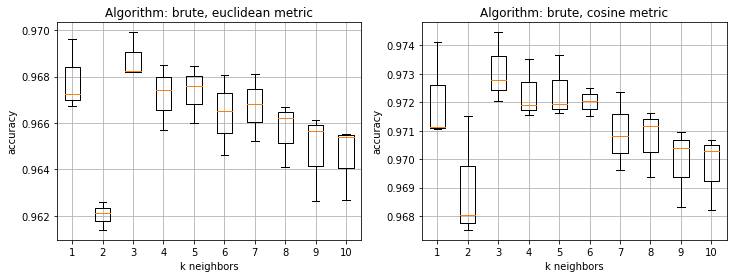

In [83]:
f, ax = plt.subplots(1,2, figsize=(12,4))
for i, metric in enumerate(metrics):
    ax[i].boxplot(list(result_unif[i].values()))
    ax[i].grid(True)
    ax[i].set_xlabel(u'k neighbors')
    ax[i].set_ylabel(u'accuracy')
    ax[i].set_title(u'Algorithm: brute, {} metric'.format(metric))

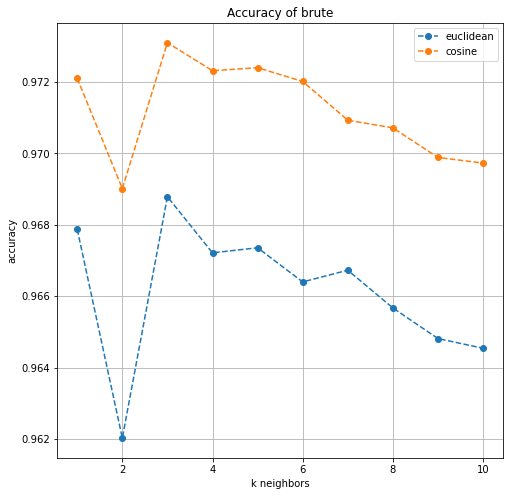

In [84]:
f, ax = plt.subplots(figsize=(8,8))
for i, metric in enumerate(metrics):
    y = np.mean(list(result_unif[i].values()), axis=1)
    plt.plot(k_list, y, 'o--', label=metric)
plt.grid(True)
plt.xlabel(u'k neighbors')
plt.ylabel(u'accuracy')
plt.title(u'Accuracy of brute')
plt.legend()

На графике видно, что:
* косинусная мера дает лучше качество на любом количестве ближайших соседей
* при двух соседях на обоих метриках падает качество, скорее всего потому что для элементах, расположенных на границах классов выбор класса становится ближе к случайному
* вообще видим, что лучше брать нечетное количество соседей, качество на них почти всегда больше, чем на рядом стоящих четных

### №3
Подадим на вход функции knn_cross_val_score взвешенный метод, сохранив все остальные параметры.

In [79]:
k_list = np.arange(1,11)
algorithm = 'brute'
metrics = ['euclidean', 'cosine']
result_dist = []
for metric in tqdm(metrics):
    result_dist.append(knn_cross_val_score(images, labels, k_list, cv=KFold(n_splits=3), weights='distance',
                                   algorithm=algorithm, metric=metric))

100%|██████████| 2/2 [04:11<00:00, 125.82s/it]


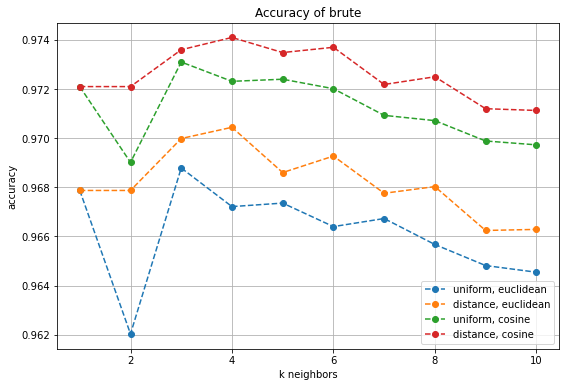

In [109]:
result = {'uniform': result_unif,
          'distance': result_dist}
f, ax = plt.subplots(figsize=(9,6))
for i, metric in enumerate(metrics):
    for j, algorithm in enumerate(['uniform', 'distance']):
        y = np.mean(list(result[algorithm][i].values()), axis=1)
        plt.plot(k_list, y, 'o--', label='{}, {}'.format(algorithm, metric))
        plt.xlabel(u'k neighbors')
        plt.ylabel(u'accuracy')
        plt.title(u'Accuracy of brute')
        plt.legend()
        plt.grid(True)

По графикам видимо, что:
* взвешенный knn дает лучшее качество как на эвклидовой, так и на косинусной мере
* косинусная мера дает лучшее качество, чем евклидова на обоих алгоритмах
* для косинусного расстояния четное количество соседей дает лучшее качество, чем нечетное
* лучшее качество дает взвешенный алгоритм с косинусным расстоянием на 4-х соседях

### №4
Применим взвешенный алгоритм 'brute' с косинусным расстоянием с 4 соседями на нашей обучающей выборке и подсчитает точность на тестовой.

In [112]:
clf = KNNClassifier(n_neighbors=4, algorithm='brute', 
                            metric='cosine', weights='distance')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
score = accuracy_score(y_pred, y_test)

Сравним точность с реализованной самостоятельно кросс-валидацией и со стандартной из библиотеки sklearn.

In [128]:
cross_vall_pred = knn_cross_val_score(images, labels, k_list=[4,5], cv=KFold(n_splits=3), 
                                   algorithm='brute', metric='cosine', weights='distance')
cross_vall_score = np.mean(list(cross_vall_pred.values()), axis=1)

In [137]:
clf_std = KNeighborsClassifier(n_neighbors=4, algorithm='brute', 
                            metric='cosine', weights='distance')
clf_std.fit(X_train, y_train)
y_train_pred = cross_val_predict(clf_std, X_train, y_train, cv=3)

In [139]:
print('Distance brute with 4 nearest neighbor and cosine metric:\nStandart score: {}'.format(score))
print('Score (with cross vallidation): {}'.format(cross_vall_score[0]))
print('Score (with cv from sklearn): {}'.format(accuracy_score(y_train_pred, y_train)))

Distance brute with 4 nearest neighbor and cosine metric:
Standart score: 0.9771
Score (with cross vallidation): 0.9740999801937931
Score (with cv from sklearn): 0.97535


На кросс валидации получаем немного меньшую точность.

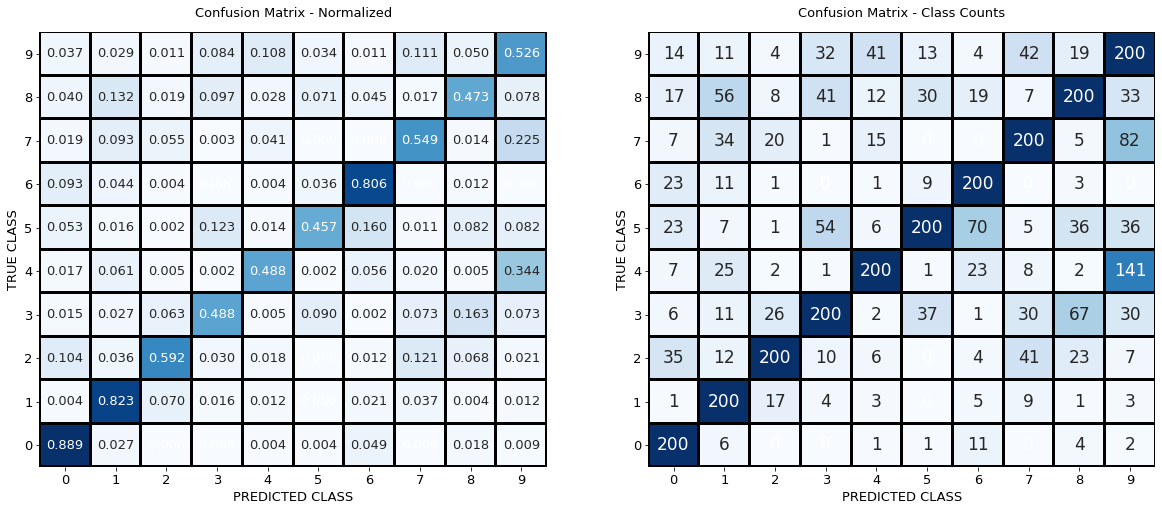

In [159]:
from plot_cm import plot_confusion_matrix
cm = confusion_matrix(y_train, y_train_pred)
for i in range(cm.shape[0]):
    cm[i,i] = 200
plot_confusion_matrix(cm, set(labels), figsize = (20,8), fontsize=13)

In [176]:
cm = confusion_matrix(y_train, y_train_pred)
for i in range(cm.shape[0]):
    cm[i,i] = 0
cm_errors = list(zip(np.arange(10), np.sum(cm, axis=1)))
print('Суммы ошибок по классам:\n', cm_errors)

Суммы ошибок по классам:
 [(0, 25), (1, 43), (2, 138), (3, 210), (4, 210), (5, 238), (6, 48), (7, 164), (8, 223), (9, 180)]


Видим, что на диагонали стоят большие числа, поскольку чаще всего мы правильно предсказываем. Диагоналные элементы матрицы зададим как 200 для наглядности, иначе они слишком большие и не видно распредление среди остальных. Обратим внимание на ошибки:
* Самая частая ошибка - 4 определяется как 9. В целом они в правду могут быть очень похоже написаны
* Следующая по частоте ошибка это 7 как 9. Менее понятно, но по схеме тоже похожие цифры
* Следующие по частоте ошибки (5 как 6) и (3 как 8).
* Больше всего ошибается классификатор предсказывая цифру 5, 8 и 3. Они все имеют достаточно сложную округлую структуру.
* В основном ошибки в правой части матрицы - меньшие числа определяются как большие. Не понятно какой из этого можно сделать вывод, может быть смещение в выборке есть.
Обратим внимание на отсутствие ошибок:
* Нет ошибок (7,6), (0, 2), (0, 3), (0, 7), (1, 5), (2, 5) и др. Видим, что простые числа хорошо классифицируются. 
* Нет ошибок (7,5) но есть (5, 7). 5 сложнее по структуре, поэтому когда ее пишут, выходит не достаточно аккуратно в некоторых случаях, скорее всего.

Посмотрим на картинки в которых ошибается классификатор, и отрисуем некоторые из них случайным образом с помощью прописанной выше функции

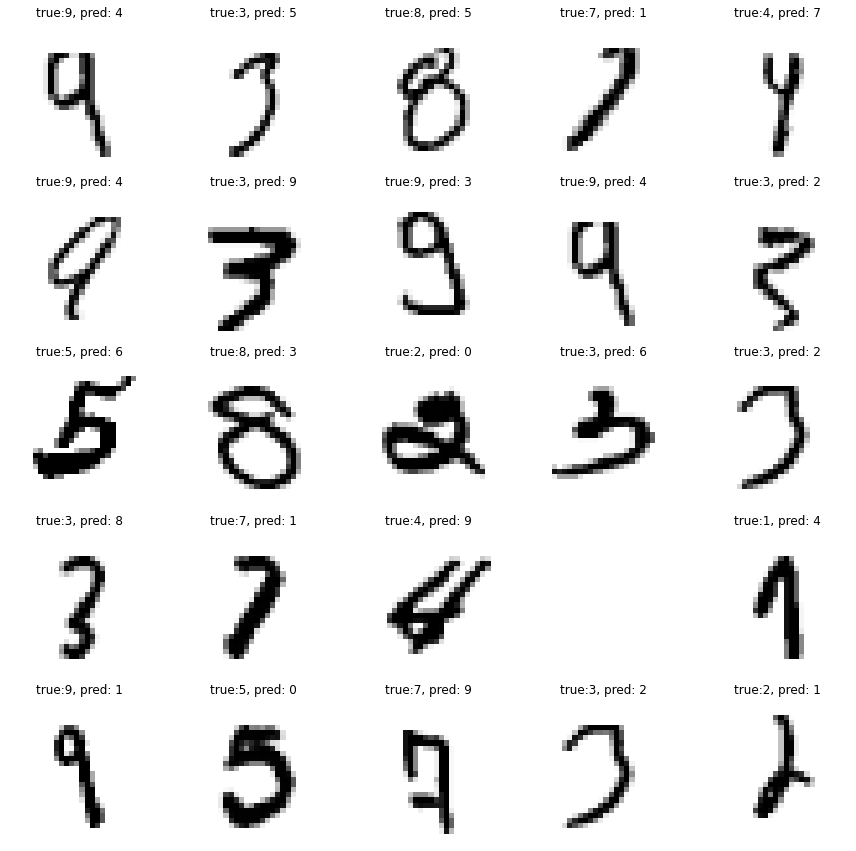

In [204]:
ind = np.where(y_pred != y_test)[0]
X_test_errors = X_test[ind]
y_test_errors = y_test[ind]
y_pred_errors = np.array(y_pred)[ind]
plot_mnist(X_test_errors, y_test_errors, 5, 5, figsize=(12,12), random_seed=42, 
           error_label=y_pred_errors, error=True)

1. У некоторых 9 как будто слегка обрезана картинка, поэтому 9 выглядит как 4. 
2. Большинство цифр как будто смешенны на ошибочных предсказаниях от центра, поэтому становятся похожими на другие.
3. Некоторые цифры неаккуратно прописаны и поэтому допускаются ошибки
4. Плохо предсказывается 8, она достаточно похожа на себя, но тем не менее путается с тройкой или 5. Стоит посмотреть отдельно на часть датасета с восьмерками